# Model Building

In [ ]:
import pandas as pd 
import numpy as np 
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from catboost import CatBoostClassifier
from scipy import stats
from scipy.stats import chi2
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay

pd.set_option("display.max_columns", None)

In [75]:
df = pd.read_csv(r"C:\Users\X1 Carbon\Desktop\IntroAI_Assignment2\processed_data.csv")
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,PhysHlth_Bin,MentHlth_Bin
0,0,1,0,1,26,0,0,0,1,0,1,0,1,0,3,5,30,0,1,4,6,8,5,1
1,0,1,1,1,26,1,1,0,0,1,0,0,1,0,3,0,0,0,1,12,6,8,0,0
2,0,0,0,1,26,0,0,0,1,1,1,0,1,0,1,0,10,0,1,13,6,8,2,0
3,0,1,1,1,28,1,0,0,1,1,1,0,1,0,3,0,3,0,1,11,6,8,1,0
4,0,0,0,1,29,1,0,0,1,1,1,0,1,0,2,0,0,0,0,8,5,8,0,0


In [129]:
X = df.drop(columns=["Diabetes_binary"])
y = df["Diabetes_binary"]

# FEATURE SELECTION AND OUTLIER REMOVAL
#X = df[["HighBP", "HighChol", "BMI", "GenHlth", "Age", "Income"]]

#q3 = X["BMI"].quantile(0.75)
#q1 = X["BMI"].quantile(0.25)
#IQR = q3 - q1
#max = q3 + 1.5 * IQR 
#min = q1 - 1.5 * IQR

#mask = (X["BMI"] >= min) & (X["BMI"] <= max)
#X = X[mask]
#y = y[mask]

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [78]:
def plot_confusion_matrix(model, x_train, y_train, x_test, y_test):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
    ConfusionMatrixDisplay.from_estimator(model, x_train, y_train, ax=ax[0], colorbar=False)
    ax[0].set_title("Train")
    ConfusionMatrixDisplay.from_estimator(model, x_test, y_test, ax=ax[1], colorbar=False)
    ax[1].set_title("Test")

def plot_ROC_AUC(model, x_train, y_train, x_test, y_test):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
    RocCurveDisplay.from_estimator(model, x_train, y_train, plot_chance_level=True, ax=ax[0])
    ax[0].set_title("Train")
    RocCurveDisplay.from_estimator(model, x_test, y_test, plot_chance_level=True, ax=ax[1])
    ax[1].set_title("Test")

def plot_feature_importance(model):
    importances = zip(X_train.columns, model.feature_importances_, )
    feature_importance = pd.DataFrame(data=importances, columns=["Feature", "Importance"])
    feature_importance.sort_values(by="Importance", inplace=True, ascending=False)
    sns.barplot(data=feature_importance, x="Importance", y="Feature")

## DecisionTree

### Baseline model

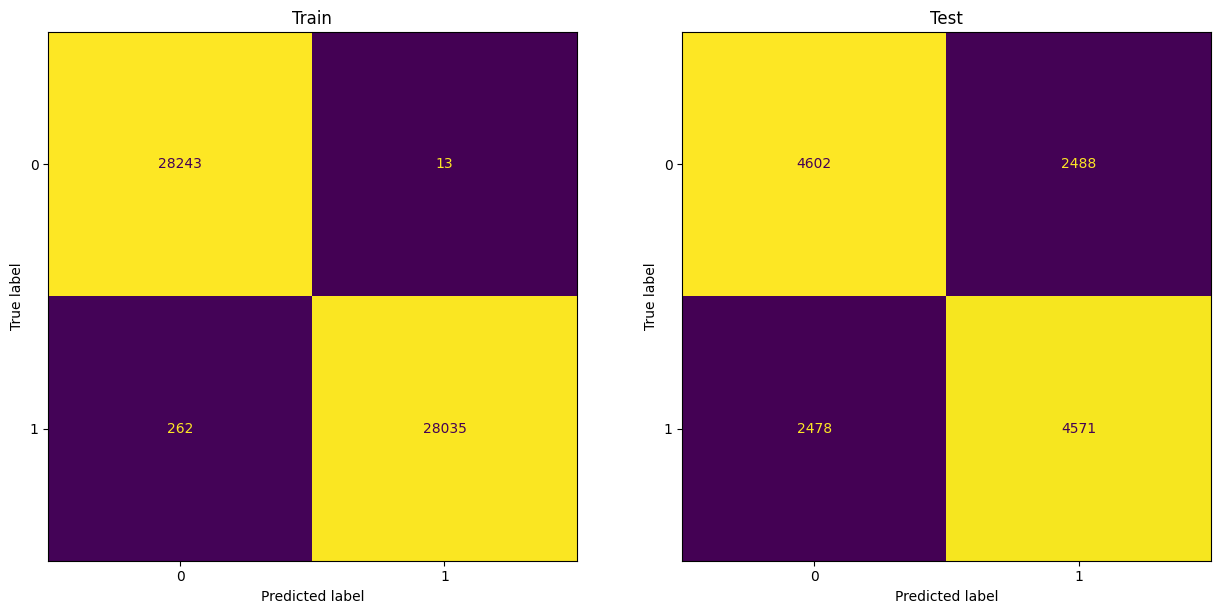

In [6]:
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)

plot_confusion_matrix(decision_tree, X_train, y_train, X_test, y_test)

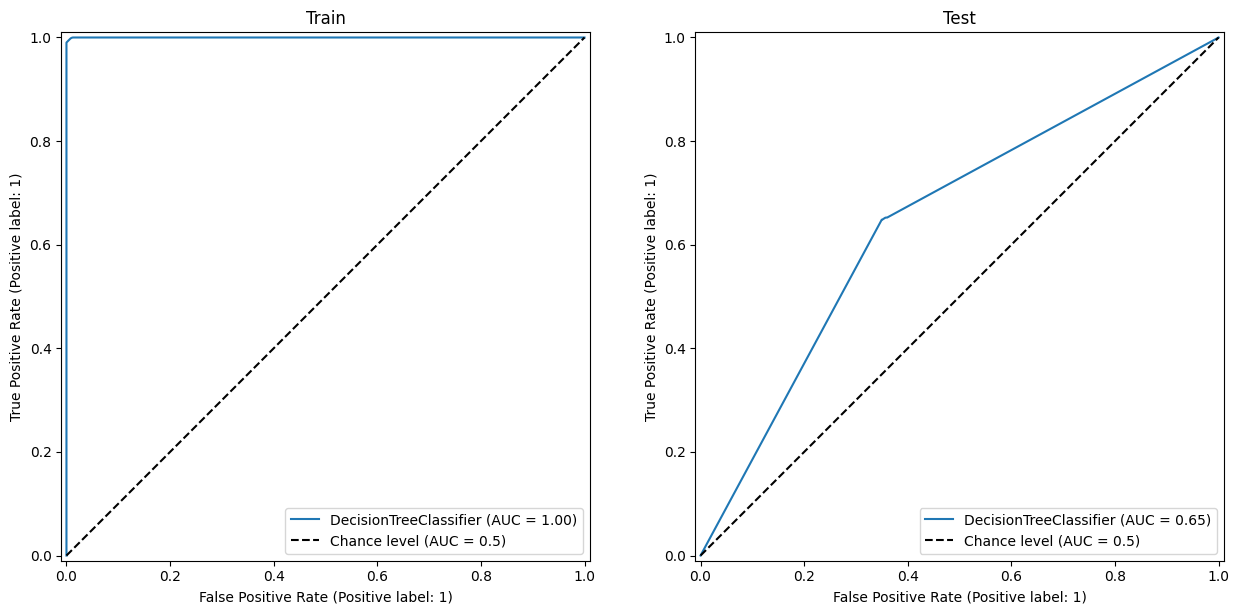

In [7]:
plot_ROC_AUC(decision_tree, X_train, y_train, X_test, y_test)

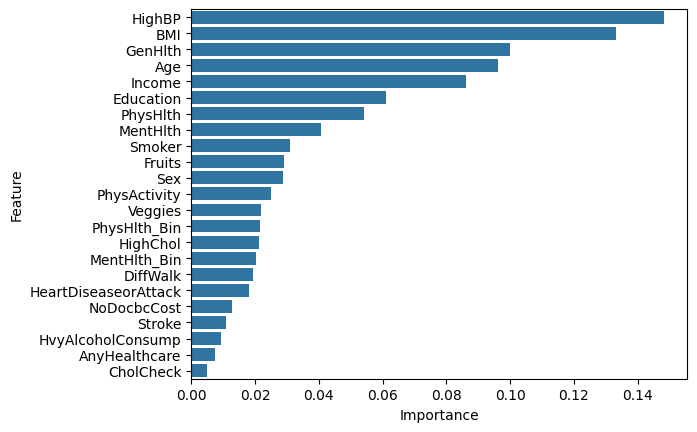

In [8]:
plot_feature_importance(decision_tree)

In [9]:
y_pred_train = decision_tree.predict(X_train)
pd.DataFrame(classification_report(y_train, y_pred_train, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.990809,0.999537,0.995137,0.995173,0.995176
recall,0.999540,0.990741,0.995137,0.995140,0.995137
f1-score,0.995155,0.995119,0.995137,0.995137,0.995137
support,28256.000000,28297.000000,0.995137,56553.000000,56553.000000


In [10]:
y_pred_test = decision_tree.predict(X_test)
pd.DataFrame(classification_report(y_test, y_pred_test, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.650000,0.647542,0.648773,0.648771,0.648775
recall,0.649083,0.648461,0.648773,0.648772,0.648773
f1-score,0.649541,0.648001,0.648773,0.648771,0.648773
support,7090.000000,7049.000000,0.648773,14139.000000,14139.000000


### Prune + Hyperparameter tuned model

In [11]:
decision_tree = DecisionTreeClassifier(random_state=42)
param_grid = {"criterion" : ["gini", "entropy"],
              "max_depth" : [i for i in range(3, 20, 2)],
              "min_samples_split" : [2, 3, 4, 5],
              "min_samples_leaf" : [1, 2, 3, 4, 5, 6]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
grid_search = GridSearchCV(estimator=decision_tree, param_grid=param_grid, cv=cv, n_jobs=-1, scoring="accuracy")
grid_search.fit(X_train, y_train)
decision_tree_grid = grid_search.best_estimator_

In [12]:
decision_tree_grid.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

In [33]:
### Calibrate classification threshold
fpr, tpr, threshold = roc_curve(y_train, decision_tree_grid.predict_proba(X_train)[:, 1])
youden_j = tpr - fpr
best_index_j = np.argmax(youden_j)
best_threshold = threshold[best_index_j]
best_threshold

np.float64(0.504950495049505)

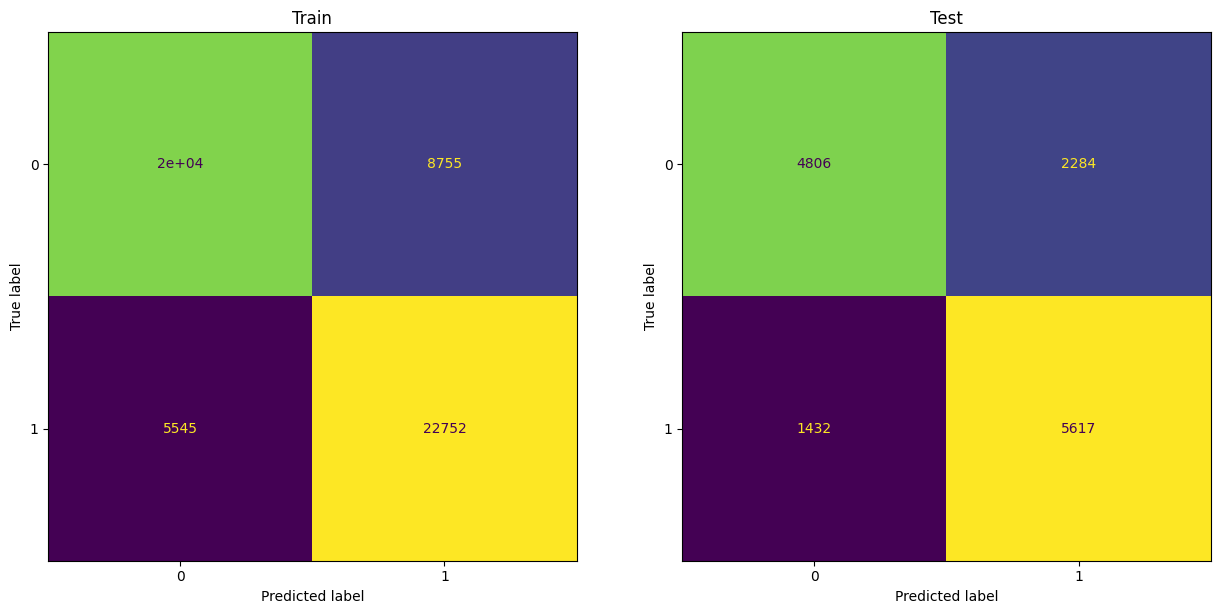

In [34]:
plot_confusion_matrix(decision_tree_grid, X_train, y_train, X_test, y_test)

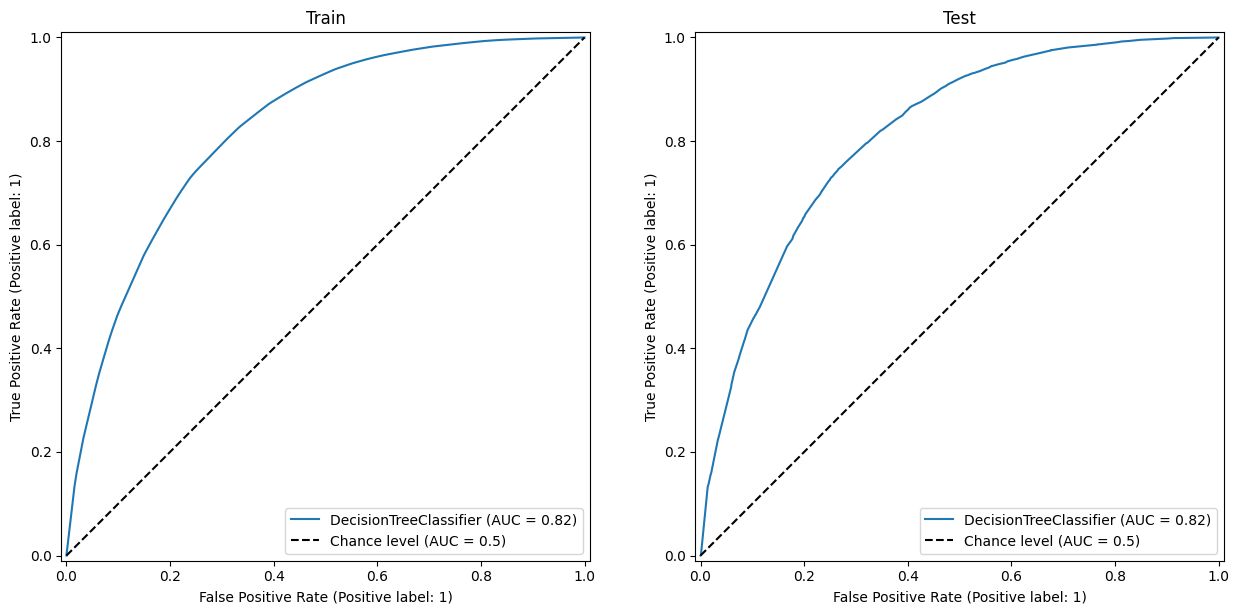

In [35]:
plot_ROC_AUC(decision_tree_grid, X_train, y_train, X_test, y_test)

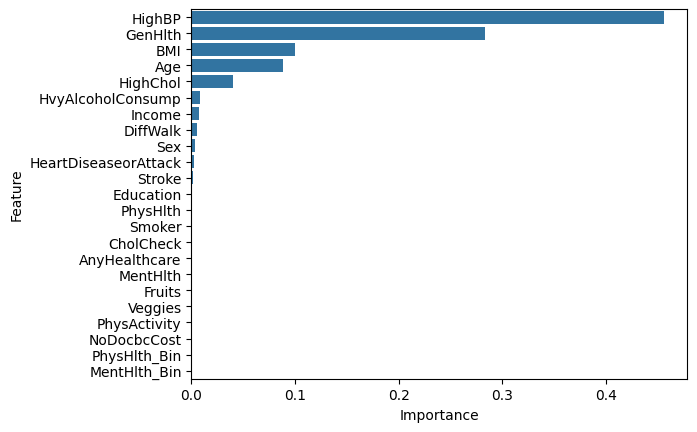

In [36]:
plot_feature_importance(decision_tree_grid)

In [37]:
y_pred_train = decision_tree_grid.predict(X_train)
pd.DataFrame(classification_report(y_train, y_pred_train, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.778607,0.722125,0.74714,0.750366,0.750346
recall,0.690154,0.804043,0.74714,0.747099,0.747140
f1-score,0.731717,0.760886,0.74714,0.746301,0.746312
support,28256.000000,28297.000000,0.74714,56553.000000,56553.000000


In [38]:
y_pred_test = decision_tree_grid.predict(X_test)
pd.DataFrame(classification_report(y_test, y_pred_test, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.770439,0.710923,0.737181,0.740681,0.740767
recall,0.677856,0.796851,0.737181,0.737353,0.737181
f1-score,0.721188,0.751438,0.737181,0.736313,0.736269
support,7090.000000,7049.000000,0.737181,14139.000000,14139.000000


## RandomForest

### Baseline model

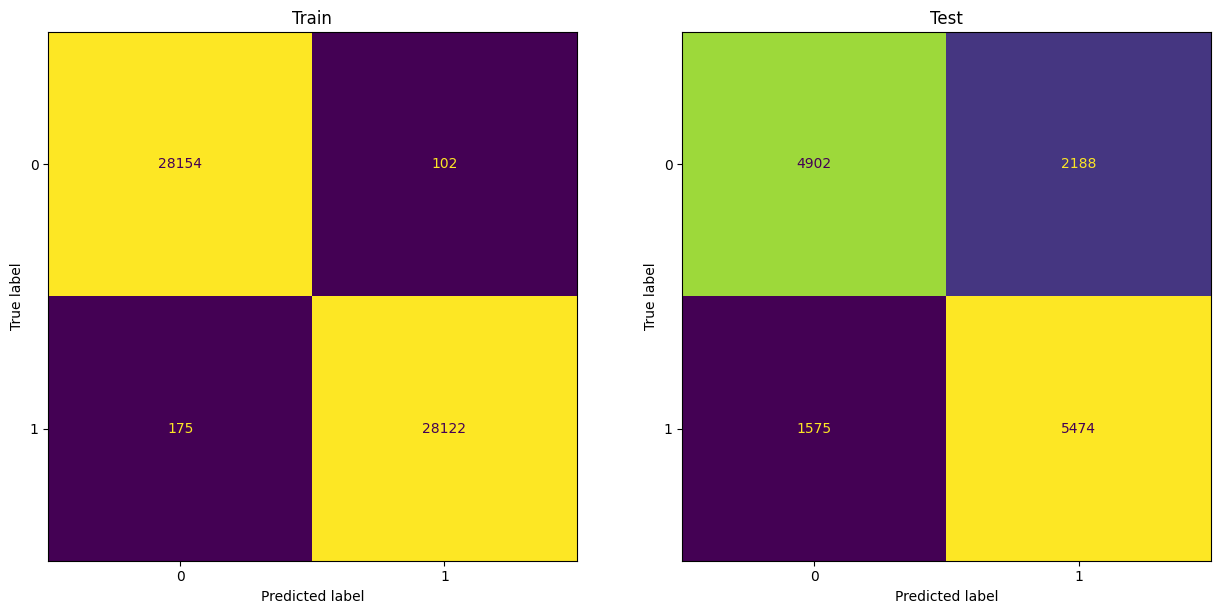

In [39]:
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train, y_train)

plot_confusion_matrix(random_forest, X_train, y_train, X_test, y_test)

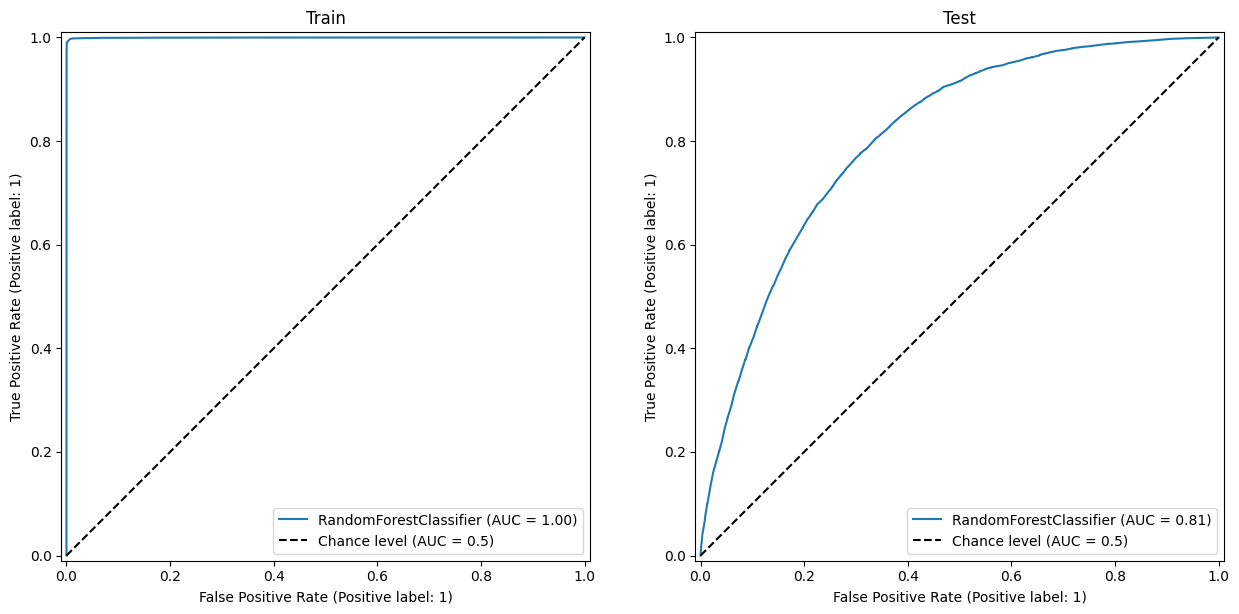

In [40]:
plot_ROC_AUC(random_forest, X_train, y_train, X_test, y_test)

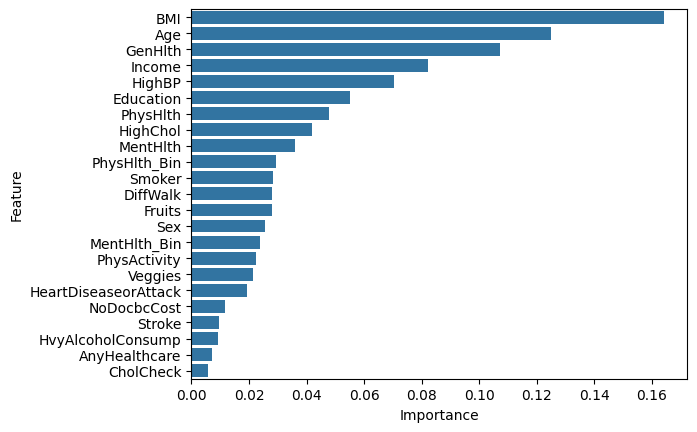

In [41]:
plot_feature_importance(random_forest)

In [42]:
y_pred_train = random_forest.predict(X_train)
pd.DataFrame(classification_report(y_train, y_pred_train, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.993823,0.996386,0.995102,0.995104,0.995105
recall,0.996390,0.993816,0.995102,0.995103,0.995102
f1-score,0.995105,0.995099,0.995102,0.995102,0.995102
support,28256.000000,28297.000000,0.995102,56553.000000,56553.000000


In [43]:
y_pred_test = random_forest.predict(X_test)
pd.DataFrame(classification_report(y_test, y_pred_test, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.756832,0.714435,0.733857,0.735633,0.735695
recall,0.691396,0.776564,0.733857,0.733980,0.733857
f1-score,0.722636,0.744205,0.733857,0.733420,0.733389
support,7090.000000,7049.000000,0.733857,14139.000000,14139.000000


### Prune + Hyperparameter tuned model

In [ ]:
random_forest = RandomForestClassifier(random_state=42, bootstrap=True, max_features="sqrt")
param_grid = {"n_estimators": [100, 150, 200],
              "criterion": ["gini", "entropy"],
              "max_depth": [i for i in range(5, 14, 2)],
              "min_samples_split": [2, 3, 4],
              "min_samples_leaf": [1, 2, 3]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=cv, n_jobs=-1, scoring="accuracy")
grid_search.fit(X_train, y_train)
random_forest_grid = grid_search.best_estimator_

In [45]:
random_forest_grid.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 11,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 150,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [46]:
### Calibrate classification threshold
fpr, tpr, threshold = roc_curve(y_train, random_forest_grid.predict_proba(X_train)[:, 1])
youden_j = tpr - fpr
best_index_j = np.argmax(youden_j)
best_threshold = threshold[best_index_j]
best_threshold

np.float64(0.5085403204245752)

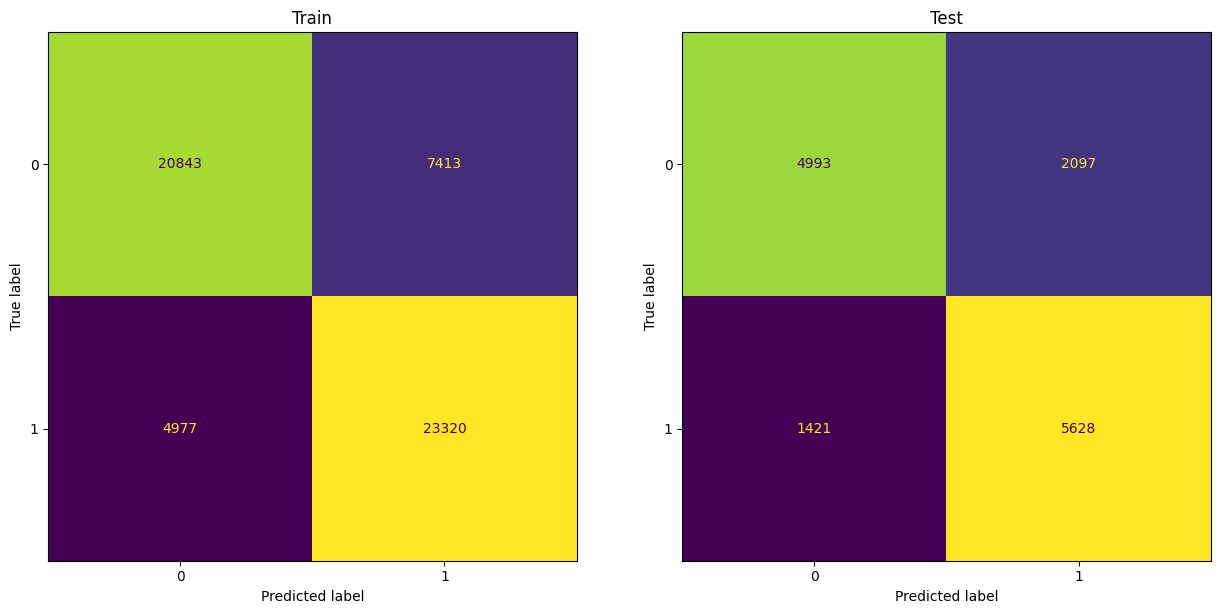

In [47]:
plot_confusion_matrix(random_forest_grid, X_train, y_train, X_test, y_test)

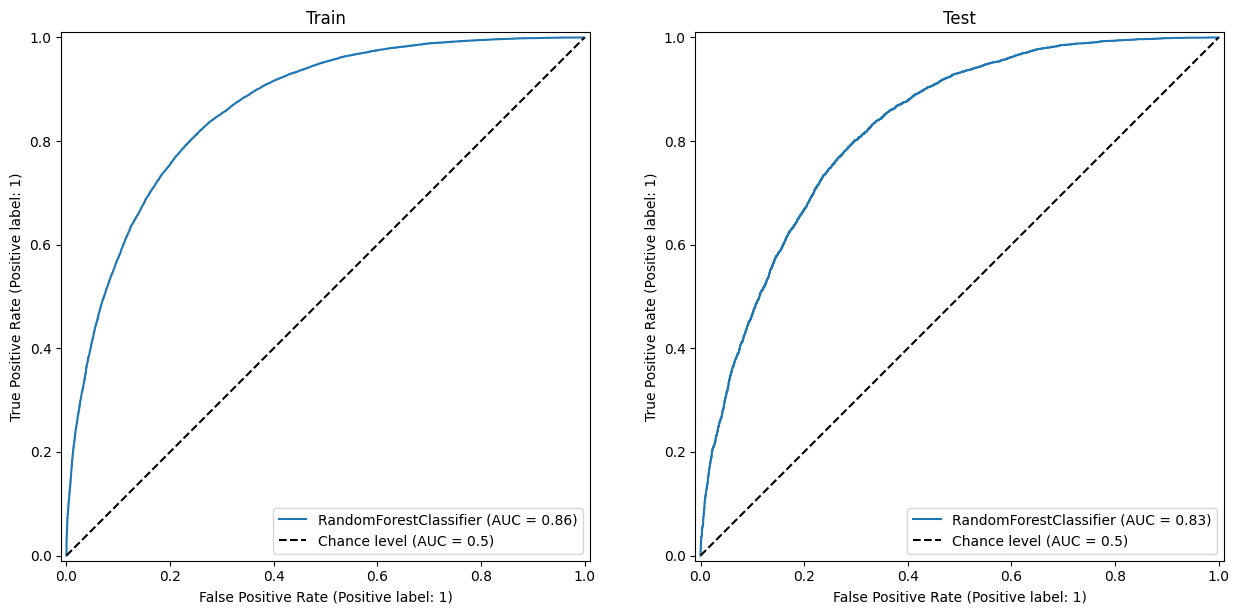

In [48]:
plot_ROC_AUC(random_forest_grid, X_train, y_train, X_test, y_test)

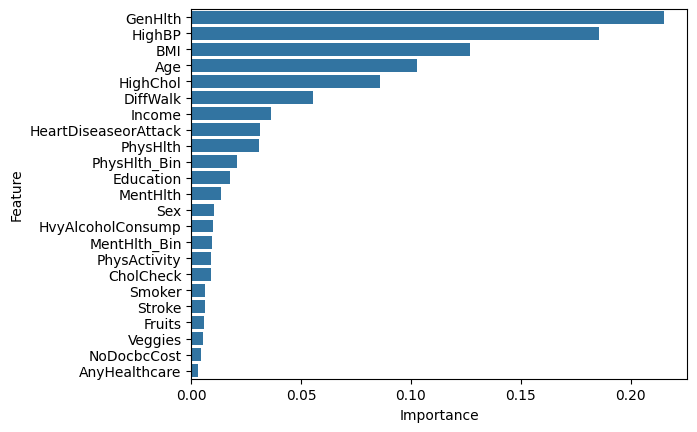

In [49]:
plot_feature_importance(random_forest_grid)

In [50]:
y_pred_train = random_forest_grid.predict(X_train)
pd.DataFrame(classification_report(y_train, y_pred_train, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.807242,0.758793,0.780913,0.783018,0.783000
recall,0.737649,0.824116,0.780913,0.780882,0.780913
f1-score,0.770878,0.790107,0.780913,0.780492,0.780499
support,28256.000000,28297.000000,0.780913,56553.000000,56553.000000


In [51]:
y_pred_test = random_forest_grid.predict(X_test)
pd.DataFrame(classification_report(y_test, y_pred_test, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.778453,0.728544,0.751185,0.753499,0.753571
recall,0.704231,0.798411,0.751185,0.751321,0.751185
f1-score,0.739485,0.761879,0.751185,0.750682,0.750649
support,7090.000000,7049.000000,0.751185,14139.000000,14139.000000


## GradientBoosting

### Baseline model

In [78]:
gradient_boosting = XGBClassifier(random_state=42)
gradient_boosting.fit(X_train, y_train)

### Calibrate classification threshold
fpr, tpr, threshold = roc_curve(y_train, gradient_boosting.predict_proba(X_train)[:, 1])
youden_j = tpr - fpr
best_index_j = np.argmax(youden_j)
best_threshold = threshold[best_index_j]
best_threshold

np.float32(0.51170635)

In [67]:
prediction = pd.DataFrame(data={"y_test" : y_test,
                                "0_prob" : gradient_boosting.predict_proba(X_test)[:, 0],
                                "1_prob" : gradient_boosting.predict_proba(X_test)[:, 1],
                                "predict_label" : (gradient_boosting.predict_proba(X_test)[:, 1] >= best_threshold).astype(int)})
prediction.head()

,y_test,0_prob,1_prob,predict_label
44967,1,0.448569,0.551431,1
20220,0,0.339509,0.660491,1
23944,0,0.560733,0.439267,0
2707,0,0.474100,0.525900,1
42356,1,0.089729,0.910271,1


In [68]:
pd.DataFrame(classification_report(y_test, prediction["predict_label"], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.765547,0.732462,0.748002,0.749005,0.749053
recall,0.717066,0.779118,0.748002,0.748092,0.748002
f1-score,0.740514,0.755070,0.748002,0.747792,0.747771
support,7090.000000,7049.000000,0.748002,14139.000000,14139.000000


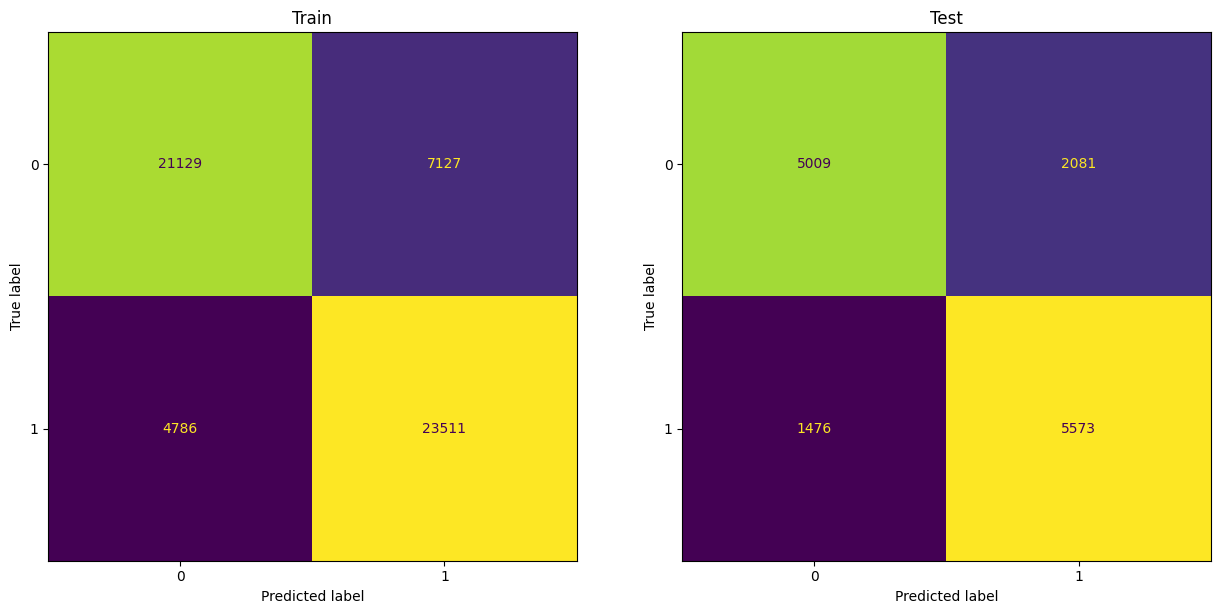

In [57]:
plot_confusion_matrix(gradient_boosting, X_train, y_train, X_test, y_test)

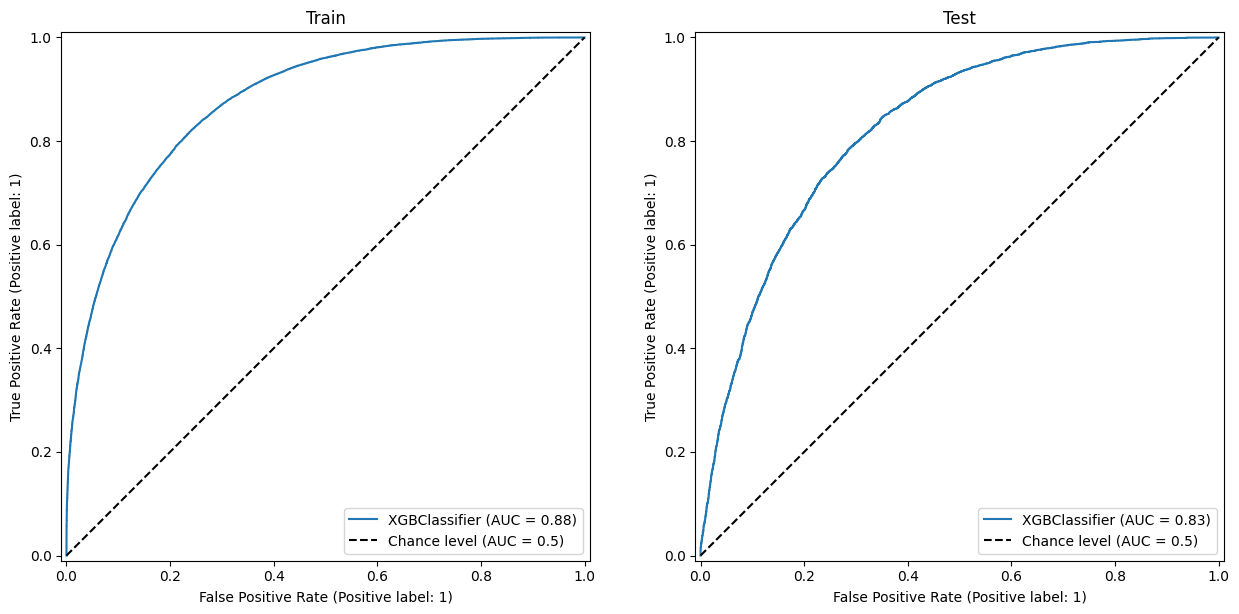

In [58]:
plot_ROC_AUC(gradient_boosting, X_train, y_train, X_test, y_test)

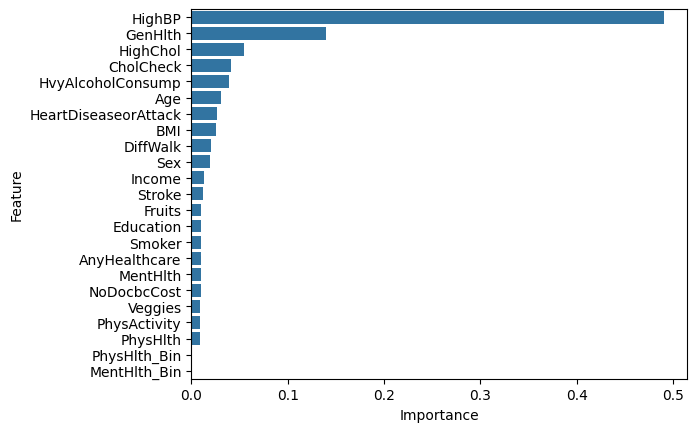

In [54]:
plot_feature_importance(gradient_boosting)

In [11]:
y_pred_train = gradient_boosting.predict(X_train)
pd.DataFrame(classification_report(y_train, y_pred_train, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.796871,0.745739,0.769888,0.771305,0.771843
recall,0.737179,0.804003,0.769888,0.770591,0.769888
f1-score,0.765863,0.773776,0.769888,0.769820,0.769736
support,27981.000000,26827.000000,0.769888,54808.000000,54808.000000


In [12]:
y_pred_test = gradient_boosting.predict(X_test)
pd.DataFrame(classification_report(y_test, y_pred_test, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.762579,0.723819,0.741808,0.743199,0.743274
recall,0.705147,0.778755,0.741808,0.741951,0.741808
f1-score,0.732739,0.750282,0.741808,0.741511,0.741477
support,6878.000000,6825.000000,0.741808,13703.000000,13703.000000


### Prune + Hyperparameter tuned model

In [82]:
gradient_boosting = XGBClassifier(random_state=42, objective="binary:logistic", importance_type="gain", eval_metric="error")
param_grid = {"n_estimators" : [150, 160, 170],
              "max_depth" : [i for i in range(5, 14, 2)],
              "max_leaves" : [i for i in range(16, 21)],
              "learning_rate" : [i*0.1 for i in range(1,11)]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
grid_search  =GridSearchCV(estimator=gradient_boosting, param_grid=param_grid, cv=cv, scoring="accuracy")
grid_search.fit(X_train, y_train)
gradient_boosting_grid = grid_search.best_estimator_

In [89]:
### Calibrate classification threshold
fpr, tpr, threshold = roc_curve(y_train, gradient_boosting_grid.predict_proba(X_train)[:, 1])
youden_j = tpr - fpr
best_index_j = np.argmax(youden_j)
best_threshold = threshold[best_index_j]
best_threshold

np.float32(0.5109052)

In [90]:
prediction = pd.DataFrame(data={"y_test" : y_test,
                                "0_prob" : gradient_boosting_grid.predict_proba(X_test)[:, 0],
                                "1_prob" : gradient_boosting_grid.predict_proba(X_test)[:, 1],
                                "predict_label" : (gradient_boosting_grid.predict_proba(X_test)[:, 1] >= best_threshold).astype(int)})
prediction.head()

,y_test,0_prob,1_prob,predict_label
44967,1,0.478738,0.521262,1
20220,0,0.358468,0.641532,1
23944,0,0.559350,0.440650,0
2707,0,0.464006,0.535994,1
42356,1,0.204754,0.795246,1


In [91]:
pd.DataFrame(classification_report(y_test, prediction["predict_label"], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.777082,0.736107,0.755075,0.756595,0.756654
recall,0.717348,0.793020,0.755075,0.755184,0.755075
f1-score,0.746021,0.763505,0.755075,0.754763,0.754738
support,7090.000000,7049.000000,0.755075,14139.000000,14139.000000


In [84]:
gradient_boosting_grid.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'error',
 'feature_types': None,
 'feature_weights': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 7,
 'max_leaves': 20,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 150,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

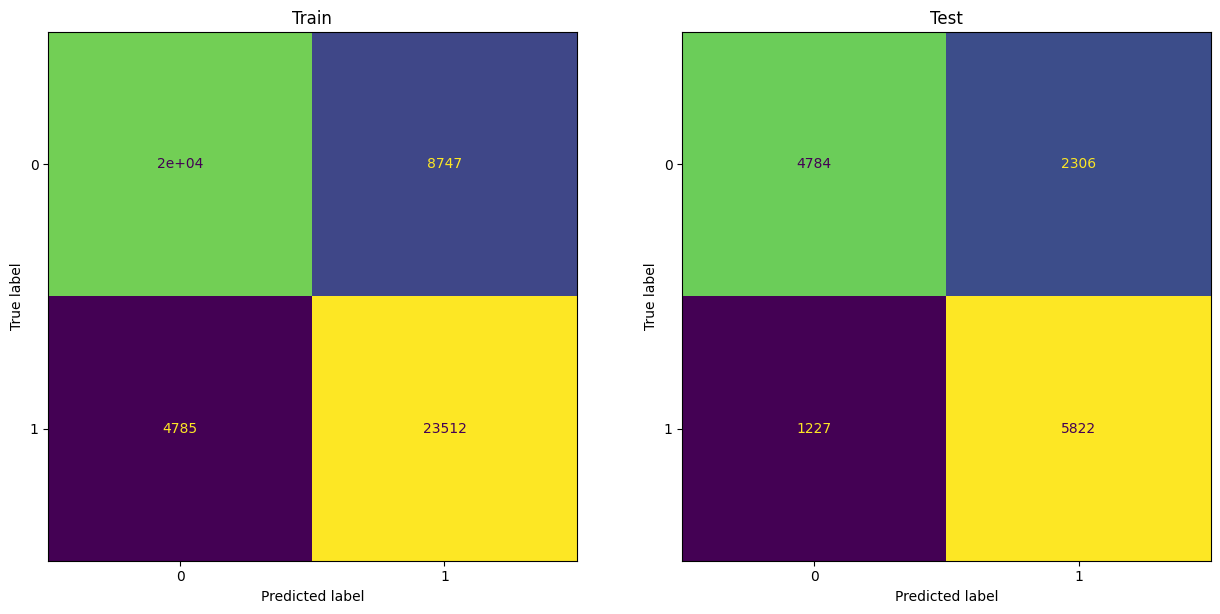

In [71]:
plot_confusion_matrix(gradient_boosting_grid, X_train, y_train, X_test, y_test)

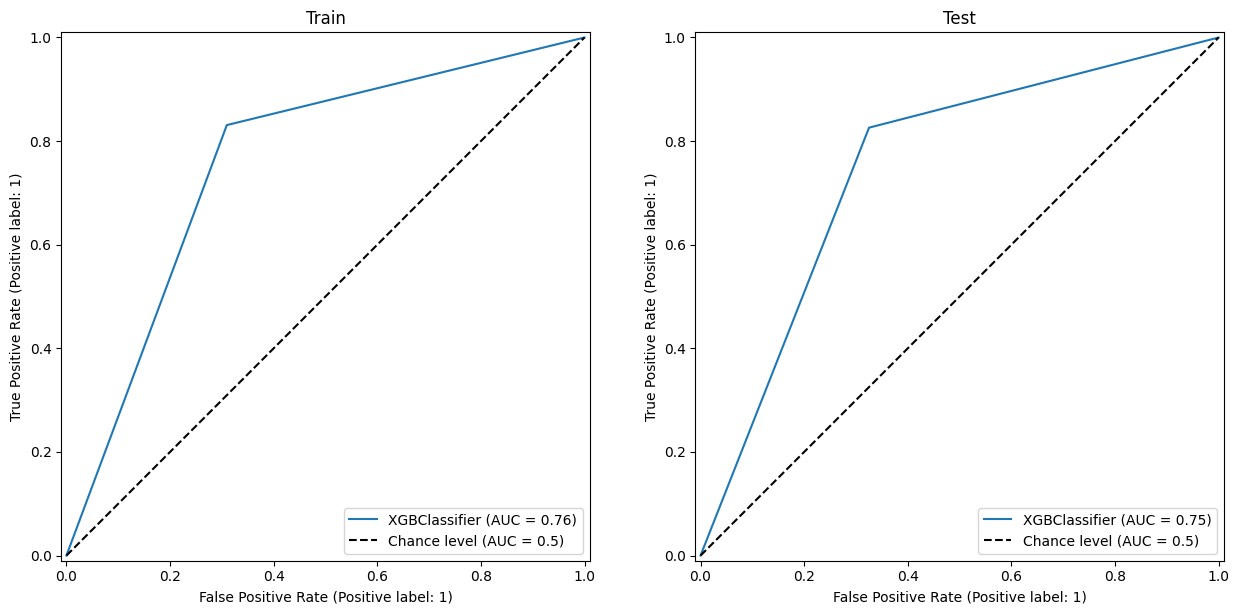

In [72]:
plot_ROC_AUC(gradient_boosting_grid, X_train, y_train, X_test, y_test)

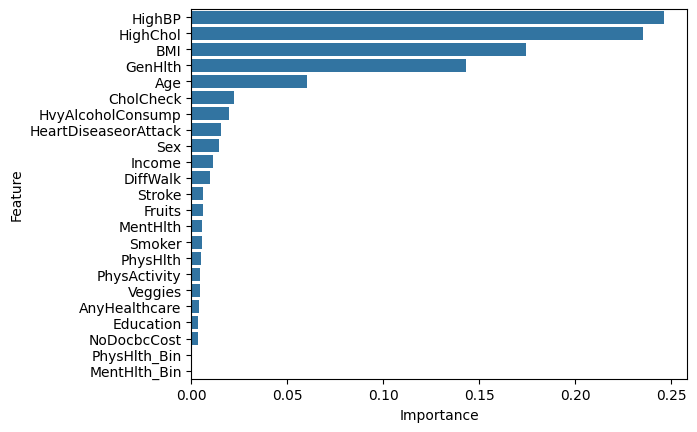

In [73]:
plot_feature_importance(gradient_boosting_grid)

In [74]:
y_pred_train = gradient_boosting_grid.predict(X_train)
pd.DataFrame(classification_report(y_train, y_pred_train, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.803038,0.728851,0.76072,0.765944,0.765917
recall,0.690437,0.830901,0.76072,0.760669,0.760720
f1-score,0.742493,0.776537,0.76072,0.759515,0.759527
support,28256.000000,28297.000000,0.76072,56553.000000,56553.000000


In [75]:
y_pred_test = gradient_boosting_grid.predict(X_test)
pd.DataFrame(classification_report(y_test, y_pred_test, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.795874,0.716289,0.750124,0.756082,0.756197
recall,0.674753,0.825933,0.750124,0.750343,0.750124
f1-score,0.730326,0.767214,0.750124,0.748770,0.748716
support,7090.000000,7049.000000,0.750124,14139.000000,14139.000000


## KNN

In [7]:
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
scaled_col = ["BMI"]

X_train_scaled[scaled_col] = scaler.fit_transform(X_train_scaled[scaled_col])
X_test_scaled[scaled_col] = scaler.transform(X_test_scaled[scaled_col])

### Baseline model

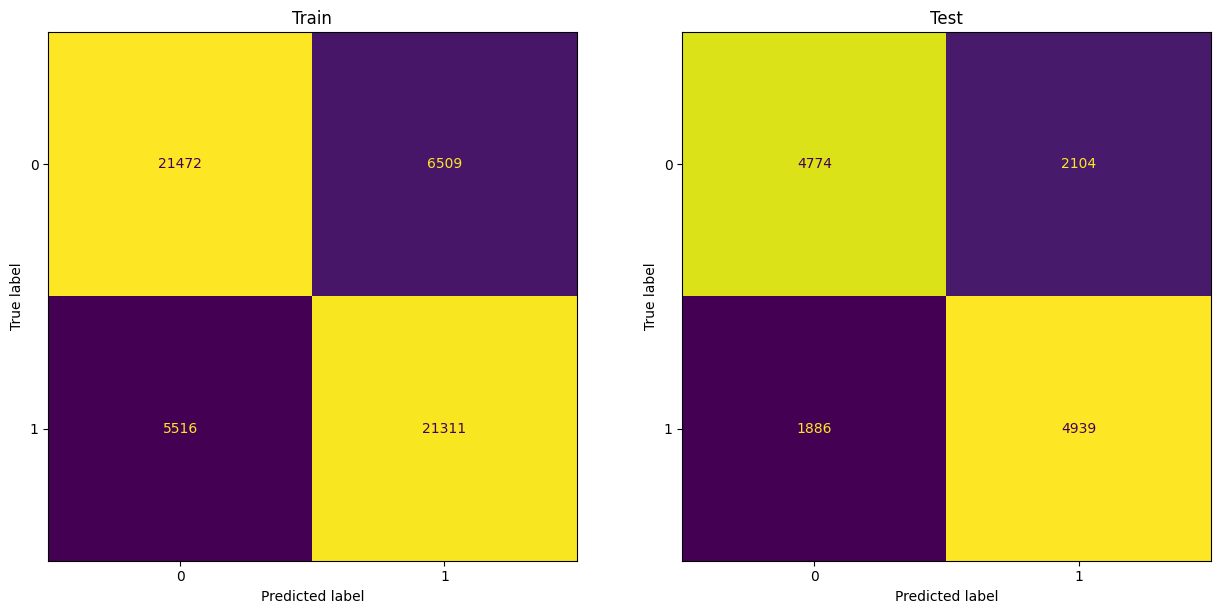

In [8]:
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
plot_confusion_matrix(knn, X_train_scaled, y_train, X_test_scaled, y_test)

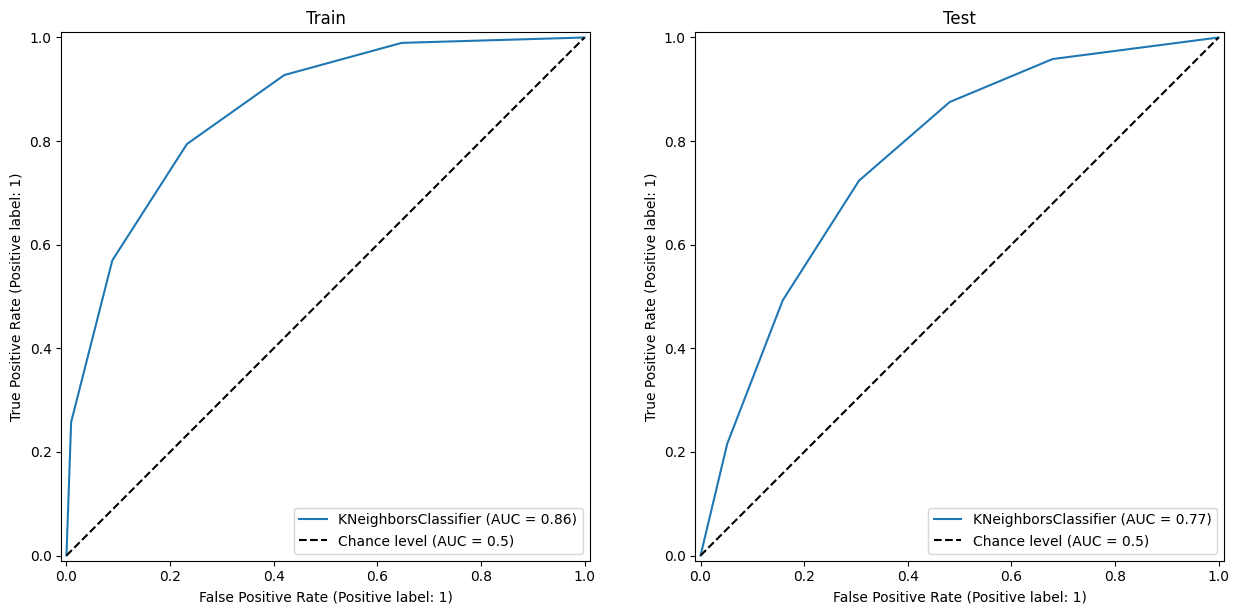

In [9]:
plot_ROC_AUC(knn, X_train_scaled, y_train, X_test_scaled, y_test)

In [10]:
y_pred_train = knn.predict(X_train_scaled)
pd.DataFrame(classification_report(y_train, y_pred_train, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.795613,0.766032,0.780598,0.780822,0.781134
recall,0.767378,0.794386,0.780598,0.780882,0.780598
f1-score,0.781240,0.779951,0.780598,0.780596,0.780609
support,27981.000000,26827.000000,0.780598,54808.000000,54808.000000


In [11]:
y_pred_test = knn.predict(X_test_scaled)
pd.DataFrame(classification_report(y_test, y_pred_test, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.716817,0.701264,0.708823,0.709040,0.709070
recall,0.694097,0.723663,0.708823,0.708880,0.708823
f1-score,0.705274,0.712287,0.708823,0.708781,0.708767
support,6878.000000,6825.000000,0.708823,13703.000000,13703.000000


### Hyperparameter tuned model

In [21]:
knn = KNeighborsClassifier(weights="uniform")
param_grid = {"n_neighbors" : [i for i in range(3, 114, 2)]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, n_jobs=-1, cv=cv, scoring="accuracy")
grid_search.fit(X_train_scaled, y_train)
knn_grid = grid_search.best_estimator_

In [22]:
knn_grid.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 113,
 'p': 2,
 'weights': 'uniform'}

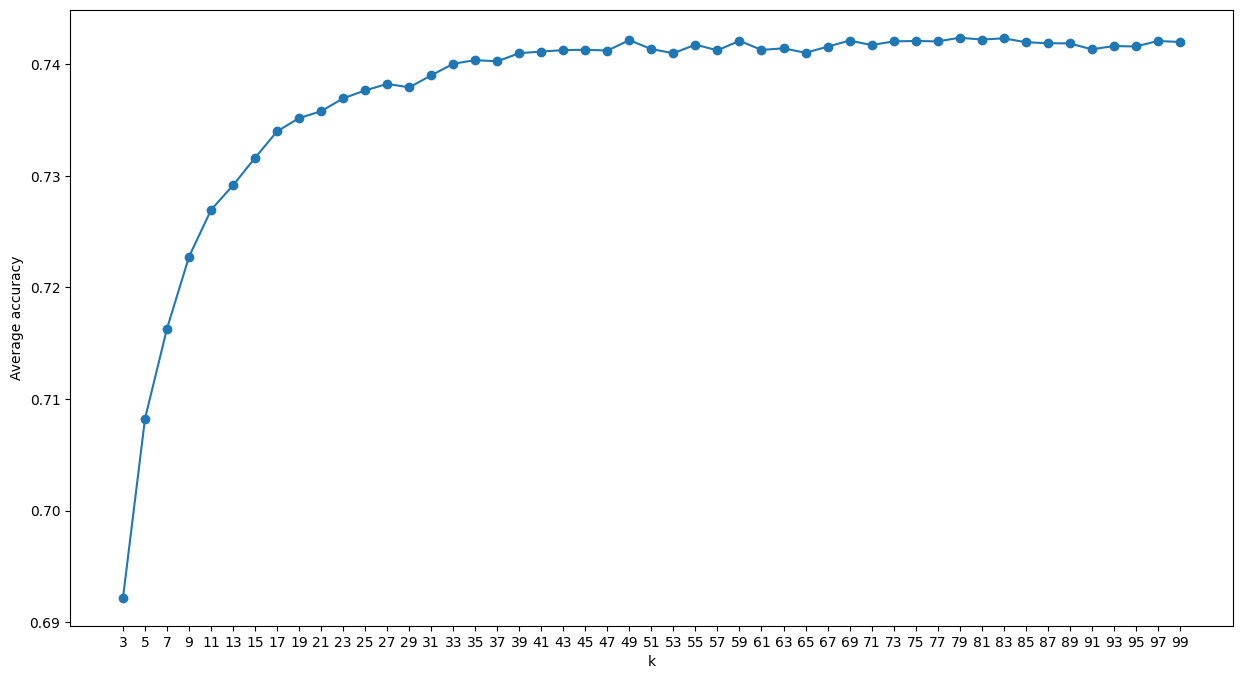

In [14]:
k_neighbor = [i for i in range(3, 101, 2)]
performance = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

for k in k_neighbor:
    knn = KNeighborsClassifier(n_neighbors=k, weights="uniform")
    scores = cross_val_score(estimator=knn, X=X_train_scaled, y=y_train, scoring="accuracy", cv=cv)
    performance.append(np.mean(scores))

performance_df = pd.DataFrame(data=performance, columns=["Average accuracy"], index=[k for k in k_neighbor])
plt.figure(figsize=(15, 8))
plt.plot(performance_df.index, performance_df["Average accuracy"], marker='o', linestyle='-')
plt.xlabel("k")
plt.ylabel("Average accuracy")
plt.xticks(performance_df.index)
plt.show()

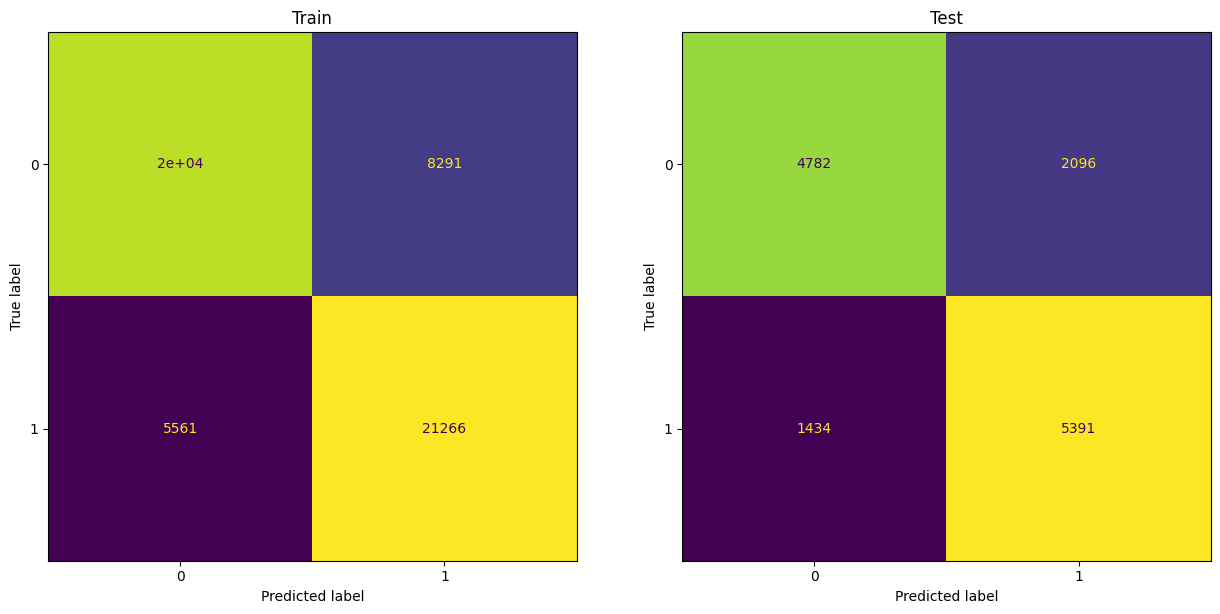

In [23]:
plot_confusion_matrix(knn_grid, X_train_scaled, y_train, X_test_scaled, y_test)

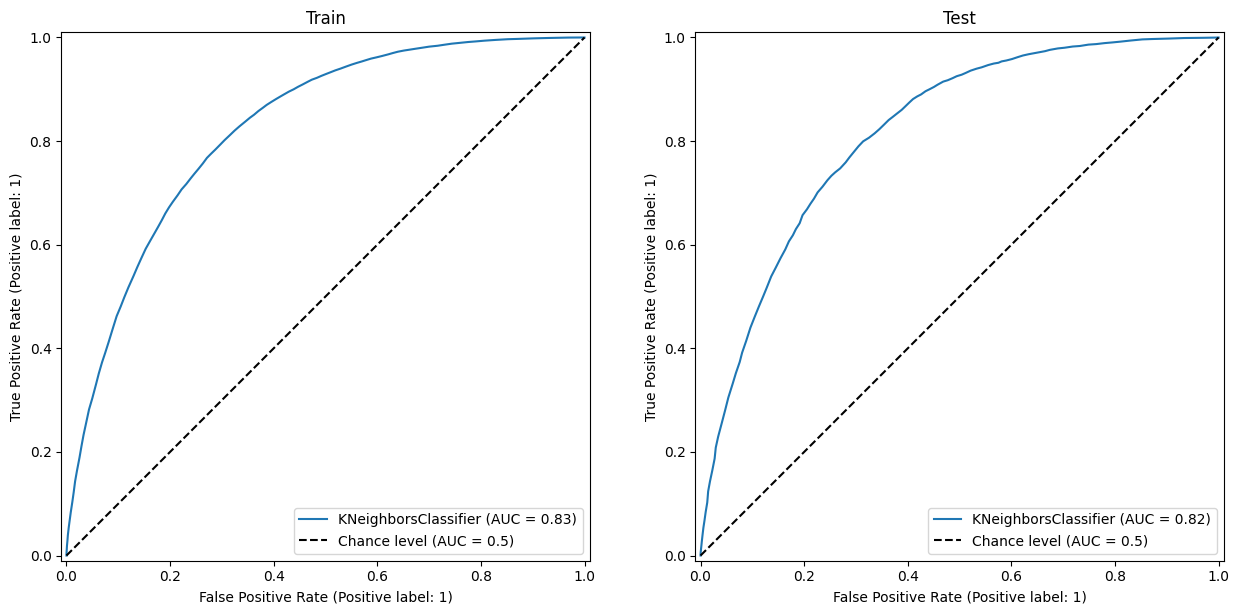

In [24]:
plot_ROC_AUC(knn_grid, X_train_scaled, y_train, X_test_scaled, y_test)

In [25]:
y_pred_train = knn_grid.predict(X_train_scaled)
pd.DataFrame(classification_report(y_train, y_pred_train, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.779771,0.719491,0.747263,0.749631,0.750266
recall,0.703692,0.792709,0.747263,0.748200,0.747263
f1-score,0.739781,0.754327,0.747263,0.747054,0.746901
support,27981.000000,26827.000000,0.747263,54808.000000,54808.000000


In [26]:
y_pred_test = knn_grid.predict(X_test_scaled)
pd.DataFrame(classification_report(y_test, y_pred_test, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.769305,0.720048,0.742392,0.744677,0.744772
recall,0.695260,0.789890,0.742392,0.742575,0.742392
f1-score,0.730411,0.753354,0.742392,0.741882,0.741838
support,6878.000000,6825.000000,0.742392,13703.000000,13703.000000


## LogisticRegression

In [102]:
def partial_omnibus_test(model_full, model_reduced):
    lr_stat = 2 * (model_full.llf - model_reduced.llf)
    df_diff = model_full.df_model - model_reduced.df_model
    p_value = stats.chi2.sf(lr_stat, df_diff)
    return {"LR statistic": lr_stat, 
            "df": df_diff, 
            "p-value": p_value}

def omnibus_test(model_full, data):
    model_null = smf.logit("Diabetes_binary ~ 1", data=data).fit(disp=0)
    lr_stat = 2 * (model_full.llf - model_null.llf)
    df_diff = model_full.df_model - model_null.df_model
    p_value = stats.chi2.sf(lr_stat, df_diff)

    return {"LR statistic": lr_stat, 
            "df": df_diff, 
            "p-value": p_value}

### Without removing outliers acc = 0.7511

In [103]:
train, test = train_test_split(df, test_size=0.2, random_state=1) ### Using statsmodel library to build regression mode, not sklearn so more convienient to have the predictors and target together rather than seperate

In [104]:
scaler = StandardScaler()
col_scale = ["BMI", "MentHlth", "PhysHlth"]
train[col_scale] = scaler.fit_transform(train[col_scale])
test[col_scale] = scaler.transform(test[col_scale])

In [105]:
logistic = smf.logit(formula="Diabetes_binary ~ BMI * Age + C(HighBP) + C(HvyAlcoholConsump) + GenHlth * Age + C(HighChol) * Age + Income + C(Sex) * Age + C(HeartDiseaseorAttack)", data=train).fit()
logistic.summary()

Optimization terminated successfully.
         Current function value: 0.513097
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        Diabetes_binary   No. Observations:                56553
Model:                          Logit   Df Residuals:                    56539
Method:                           MLE   Df Model:                           13
Date:                Sat, 13 Sep 2025   Pseudo R-squ.:                  0.2598
Time:                        10:01:11   Log-Likelihood:                -29017.
converged:                       True   LL-Null:                       -39199.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -4.6818      0.133    -35.187      0.000      -4.943      -4.421
C(HighBP)[T.1]                   0.7515      0.022     34.056      0.000       0.708       0.795
C(HvyAlcoholConsump)[T.1]       -0.8344      0.054    -15.379      0.000      -0.941      -0.728
C(HighChol)[T.1]                 1.3739      0.074     18.487      0.000       1.228       1.520
C(Sex)[T.1]                     -0.2306      0.074     -3.106      0.002      -0.376      -0.085
C(HeartDiseaseorAttack)[T.1]     0.2862      0.031      9.157      0.000       0.225       0.348
BMI                              0.2044      0.036      5.623      0.000       0.133       0.276
Age                              0.2937      0.013     21.982      0.000       0.267       0.320
C(HighChol)[T.1]:Age            -0.0865      0.008    -10.883      0.000      -0.102      -0.071
C(Sex)[T.1]:Age                  0.0543      0.008      6.816      0.000       0.039       0.070
BMI:Age                          0.0407      0.004      9.603      0.000       0.032       0.049
GenHlth                          0.9197      0.038     23.990      0.000       0.845       0.995
GenHlth:Age                     -0.0404      0.004    -10.028      0.000      -0.048      -0.033
Income                          -0.0578      0.005    -11.205      0.000      -0.068      -0.048
================================================================================================
"""

In [460]:
logistic_reduced = smf.logit(formula="Diabetes_binary ~ BMI * Age + C(HighBP) + C(HvyAlcoholConsump) + GenHlth * Age + C(HighChol) * Age + Income + C(Sex) * Age + C(HeartDiseaseorAttack)", data=train).fit(disp=0)
partial_omnibus_test(logistic, logistic_reduced)

{'LR statistic': np.float64(0.0), 'df': 0.0, 'p-value': np.float64(nan)}

In [106]:
### Calibrate classification threshold
fpr, tpr, threshold = roc_curve(train["Diabetes_binary"], logistic.predict(train))
youden_j = tpr - fpr
best_index_j = np.argmax(youden_j)
best_threshold = threshold[best_index_j]
best_threshold

np.float64(0.47157649635830223)

In [107]:
prediction_train = pd.DataFrame({"y_true" : train["Diabetes_binary"],
                           "prob" : logistic.predict(train),
                           "y_pred" : (logistic.predict(train) >= best_threshold).astype(int)})

prediction_test = pd.DataFrame({"y_true" : test["Diabetes_binary"],
                           "prob" : logistic.predict(test),
                           "y_pred" : (logistic.predict(test) >= best_threshold).astype(int)})

In [108]:
# TRAIN
pd.DataFrame(classification_report(prediction_train["y_true"], prediction_train["y_pred"], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.777341,0.725194,0.748431,0.751268,0.751202
recall,0.694522,0.802067,0.748431,0.748295,0.748431
f1-score,0.733602,0.761696,0.748431,0.747649,0.747684
support,28205.000000,28348.000000,0.748431,56553.000000,56553.000000


In [109]:
# TEST
pd.DataFrame(classification_report(prediction_test["y_true"], prediction_test["y_pred"], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.785803,0.727778,0.754084,0.756791,0.757084
recall,0.705363,0.803801,0.754084,0.754582,0.754084
f1-score,0.743414,0.763903,0.754084,0.753658,0.753555
support,7141.000000,6998.000000,0.754084,14139.000000,14139.000000


In [425]:
omnibus_test(logistic, train)

{'LR statistic': np.float64(20403.26048451924),
 'df': 14.0,
 'p-value': np.float64(0.0)}

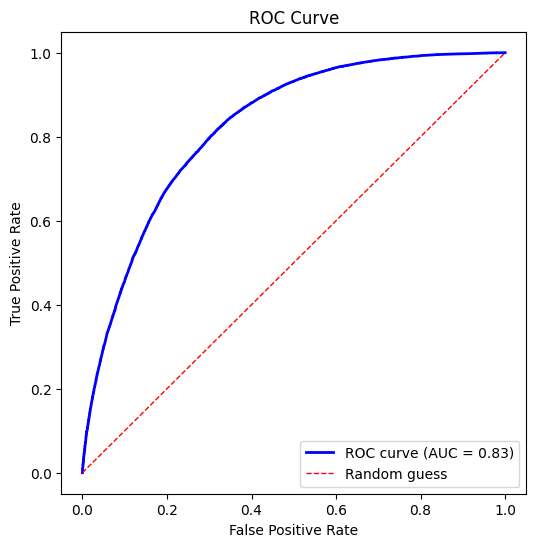

In [59]:
# statsmodels predict() gives probability of class 1
y_pred_proba = logistic.predict(train)  # or df_test for test set
from sklearn.metrics import auc

y_true = train["Diabetes_binary"]  # or y_test
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='red', lw=1, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


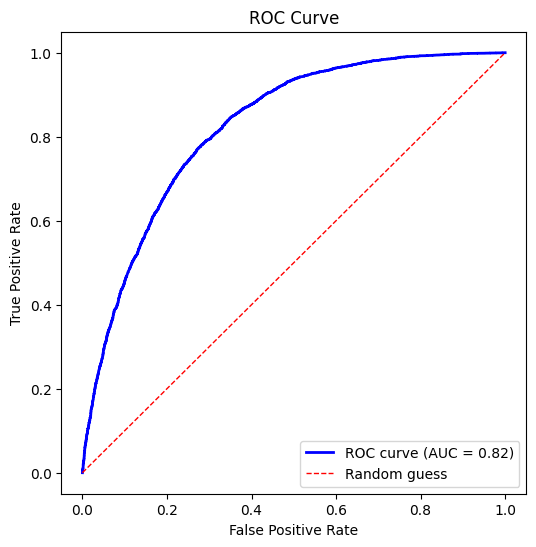

In [60]:
# statsmodels predict() gives probability of class 1
y_pred_proba = logistic.predict(test)  # or df_test for test set
from sklearn.metrics import auc

y_true = test["Diabetes_binary"]  # or y_test
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='red', lw=1, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


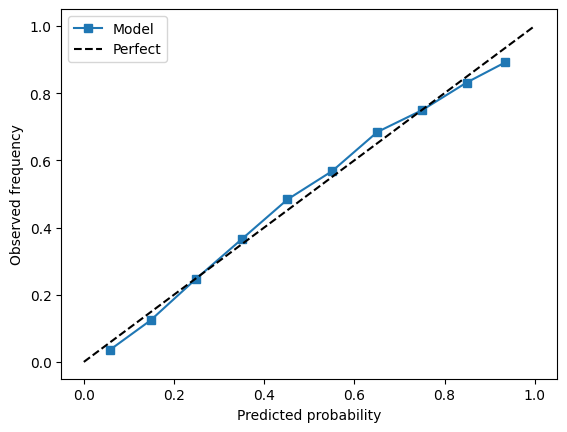

In [156]:
y_true = train["Diabetes_binary"]
y_pred_proba = logistic.predict(train)
prob_true, prob_pred = calibration_curve(y_true, y_pred_proba, n_bins=10)

plt.plot(prob_pred, prob_true, 's-', label='Model')
plt.plot([0,1], [0,1], 'k--', label='Perfect')
plt.xlabel('Predicted probability')
plt.ylabel('Observed frequency')
plt.legend()
plt.show()


## CatBoosting

### Baseline model

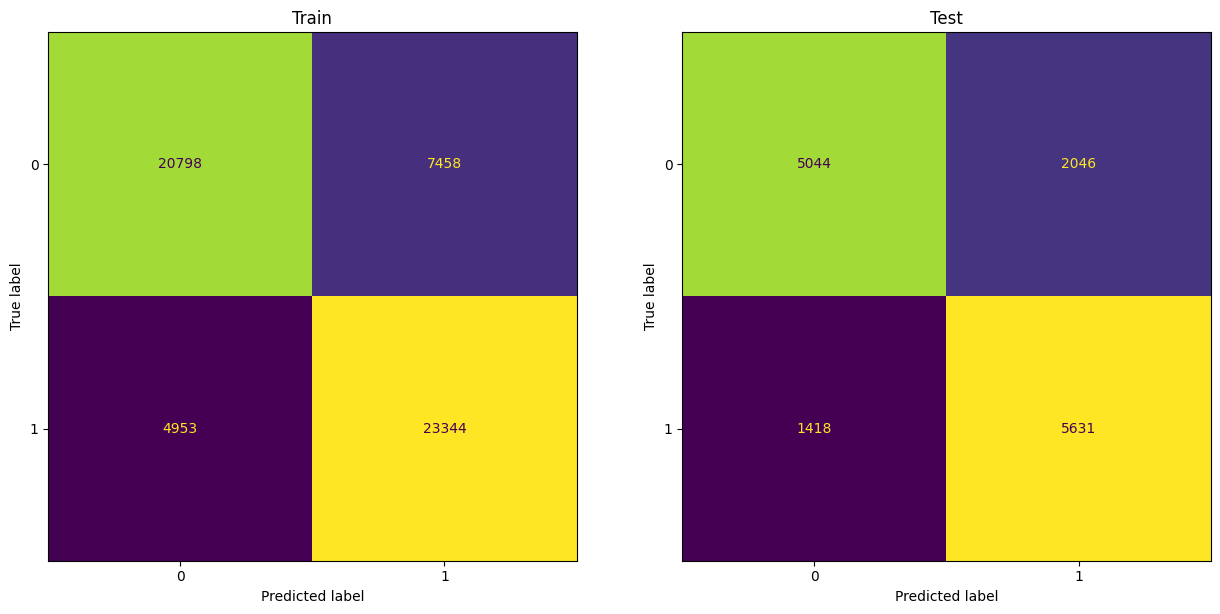

In [112]:
catboost = CatBoostClassifier(verbose=0)
catboost.fit(X_train, y_train)

plot_confusion_matrix(catboost, X_train, y_train, X_test, y_test)

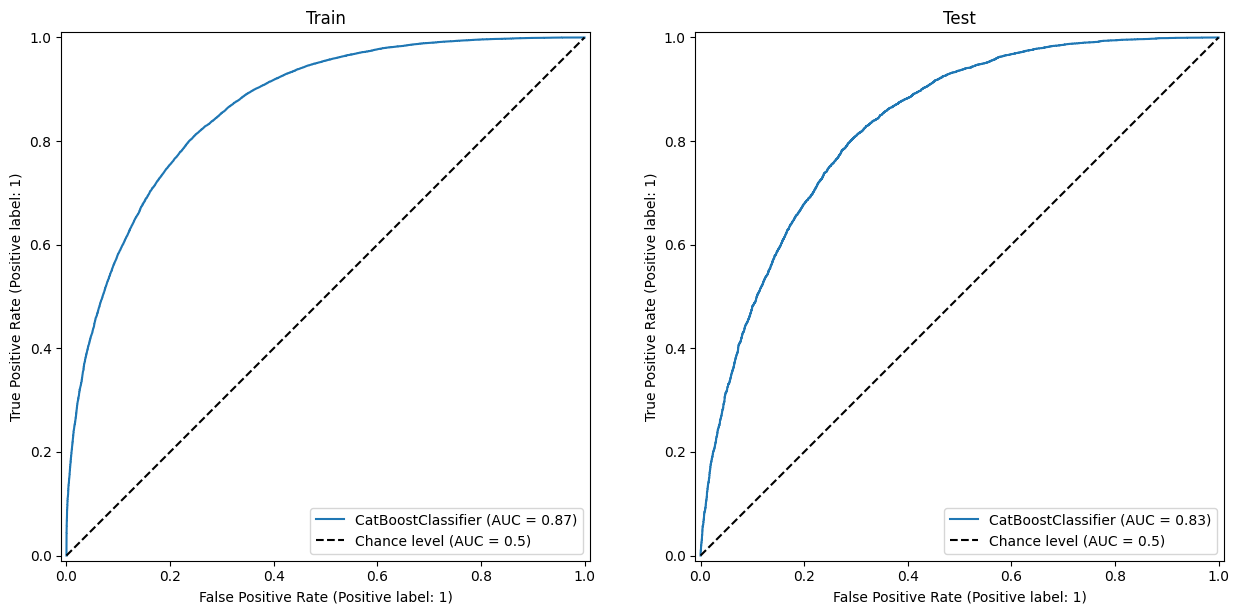

In [113]:
plot_ROC_AUC(catboost, X_train, y_train, X_test, y_test)

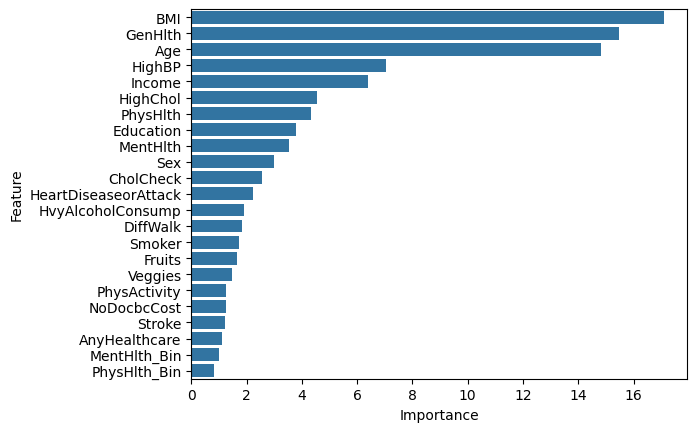

In [114]:
plot_feature_importance(catboost)

In [119]:
### Calibrate classification threshold
fpr, tpr, threshold = roc_curve(y_train, catboost.predict_proba(X_train)[:, 1])
youden_j = tpr - fpr
best_index_j = np.argmax(youden_j)
best_threshold = threshold[best_index_j]
best_threshold

np.float64(0.5157280603660283)

In [120]:
prediction = pd.DataFrame(data={"y_test" : y_test,
                                "0_prob" : catboost.predict_proba(X_test)[:, 0],
                                "1_prob" : catboost.predict_proba(X_test)[:, 1],
                                "predict_label" : (catboost.predict_proba(X_test)[:, 1] >= best_threshold).astype(int)})
prediction.head()

,y_test,0_prob,1_prob,predict_label
44967,1,0.453394,0.546606,1
20220,0,0.360872,0.639128,1
23944,0,0.546210,0.453790,0
2707,0,0.448875,0.551125,1
42356,1,0.149238,0.850762,1


In [ ]:
pd.DataFrame(classification_report(y_test, prediction["predict_label"], output_dict=True)) ### Performance of calibrated threshold

,0,1,accuracy,macro avg,weighted avg
precision,0.772207,0.738429,0.754297,0.755318,0.755367
recall,0.723413,0.785360,0.754297,0.754386,0.754297
f1-score,0.747014,0.761171,0.754297,0.754093,0.754072
support,7090.000000,7049.000000,0.754297,14139.000000,14139.000000


In [82]:
y_pred_train = catboost.predict(X_train)
pd.DataFrame(classification_report(y_train, y_pred_train, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.807658,0.757873,0.780542,0.782765,0.782747
recall,0.736056,0.824964,0.780542,0.780510,0.780542
f1-score,0.770196,0.789996,0.780542,0.780096,0.780104
support,28256.000000,28297.000000,0.780542,56553.000000,56553.000000


In [83]:
y_pred_test = catboost.predict(X_test)
pd.DataFrame(classification_report(y_test, y_pred_test, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.780563,0.733490,0.755004,0.757026,0.757095
recall,0.711425,0.798837,0.755004,0.755131,0.755004
f1-score,0.744392,0.764770,0.755004,0.754581,0.754551
support,7090.000000,7049.000000,0.755004,14139.000000,14139.000000


### Prune + hyperparameter tuned model

In [92]:
cat_features = list(X_train.columns.drop(["BMI", "PhysHlth", "MentHlth", "Income", "Education", "Age", "GenHlth", "PhysHlth_Bin", "MentHlth_Bin"]))
catboost = CatBoostClassifier(cat_features=cat_features, random_seed=42, verbose=False)
param_grid = {"learning_rate" : [i*0.1 for i in range(1,11)],
              "iterations" : [100, 150, 200],
              "depth" : [i for i in range(4,11)]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
grid_search  =GridSearchCV(estimator=catboost, param_grid=param_grid, cv=cv, scoring="accuracy")
grid_search.fit(X_train, y_train)
catboost_grid = grid_search.best_estimator_

In [97]:
catboost_grid.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 100,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'max_ctr_complexity': 1,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderT

In [122]:
### Calibrate classification threshold
fpr, tpr, threshold = roc_curve(y_train, catboost_grid.predict_proba(X_train)[:, 1])
youden_j = tpr - fpr
best_index_j = np.argmax(youden_j)
best_threshold = threshold[best_index_j]
best_threshold

np.float64(0.504991008184713)

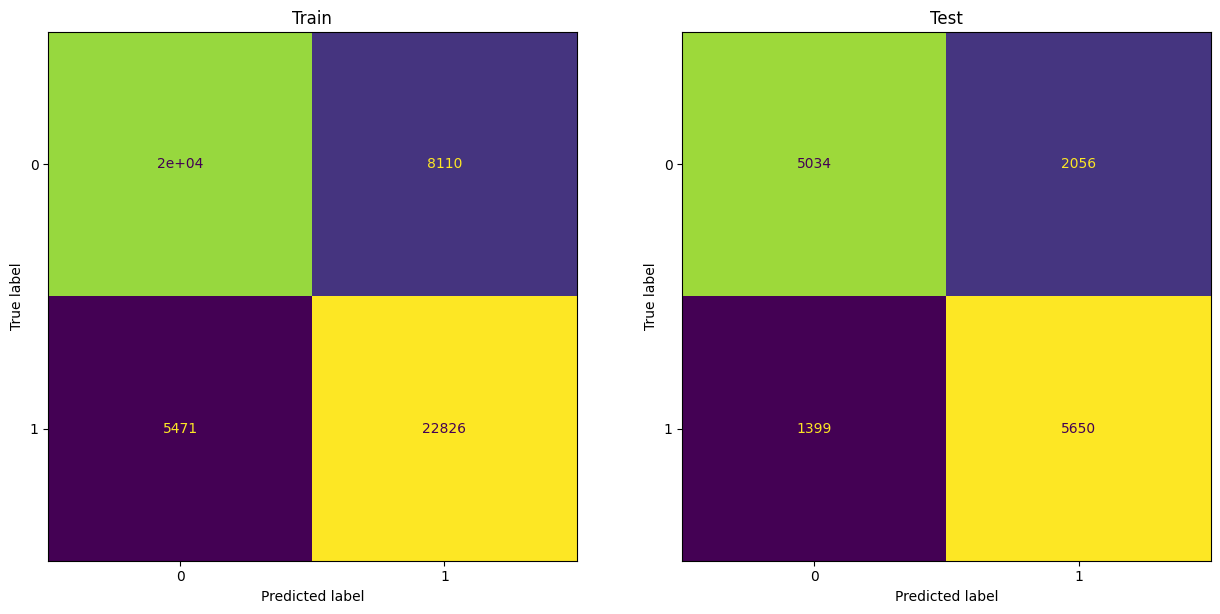

In [93]:
plot_confusion_matrix(catboost_grid, X_train, y_train, X_test, y_test)

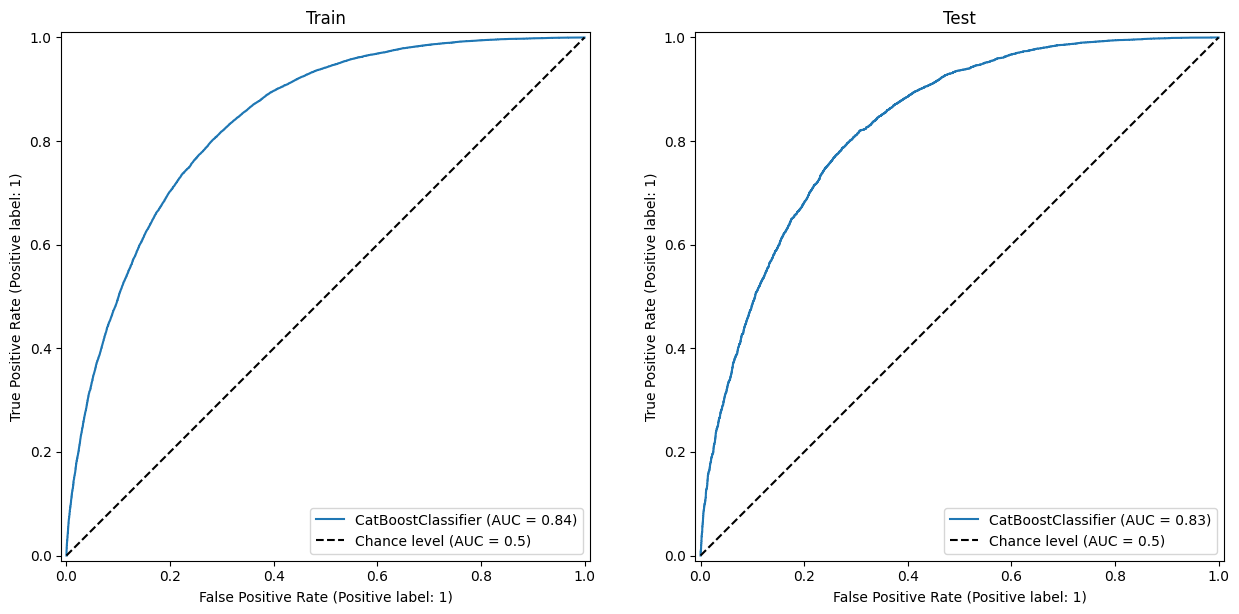

In [94]:
plot_ROC_AUC(catboost_grid, X_train, y_train, X_test, y_test)

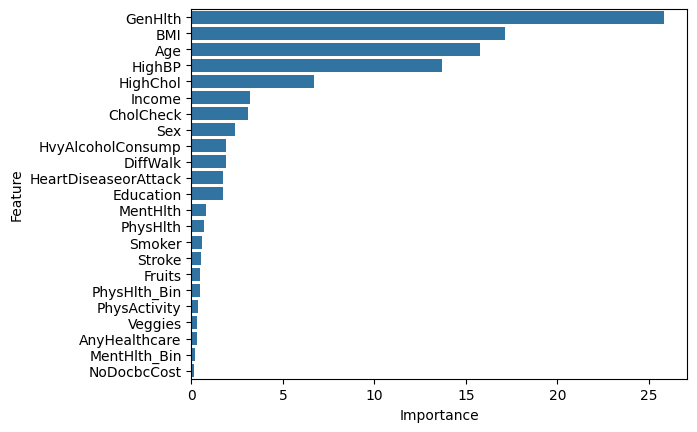

In [95]:
plot_feature_importance(catboost_grid)

In [98]:
y_pred_train = catboost_grid.predict(X_train)
pd.DataFrame(classification_report(y_train, y_pred_train, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.786431,0.737846,0.759854,0.762138,0.762121
recall,0.712981,0.806658,0.759854,0.759820,0.759854
f1-score,0.747907,0.770719,0.759854,0.759313,0.759321
support,28256.000000,28297.000000,0.759854,56553.000000,56553.000000


In [99]:
y_pred_test = catboost_grid.predict(X_test)
pd.DataFrame(classification_report(y_test, y_pred_test, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.782528,0.733195,0.75564,0.757861,0.757933
recall,0.710014,0.801532,0.75564,0.755773,0.755640
f1-score,0.744509,0.765842,0.75564,0.755176,0.755145
support,7090.000000,7049.000000,0.75564,14139.000000,14139.000000
